## **Images & masks directory list**

In [2]:
# make lists for image and mask directories
import glob

images_dir = '/outputs/dataset/images'
masks_dir = '/outputs/dataset/masks'

image_paths = sorted(glob.glob(f'{images_dir}/*'))
mask_paths = sorted(glob.glob(f'{masks_dir}/*'))

print(image_paths)
print(mask_paths)

['/content/dataset/images/processed_image+final_00001_a0.png', '/content/dataset/images/processed_image+final_00002_a0.png', '/content/dataset/images/processed_image+final_00003_a0.png', '/content/dataset/images/processed_image+final_00004_a0.png', '/content/dataset/images/processed_image+final_00005_a0.png', '/content/dataset/images/processed_image+final_00006_a0.png', '/content/dataset/images/processed_image+final_00007_a0.png', '/content/dataset/images/processed_image+final_00008_a0.png', '/content/dataset/images/processed_image+final_00009_a0.png', '/content/dataset/images/processed_image+final_00010_a0.png', '/content/dataset/images/processed_image+final_00011_a0.png', '/content/dataset/images/processed_image+final_00012_a0.png', '/content/dataset/images/processed_image+final_00013_a0.png', '/content/dataset/images/processed_image+final_00014_a0.png', '/content/dataset/images/processed_image+final_00015_a0.png', '/content/dataset/images/processed_image+final_00016_a0.png', '/conte

## **Prepare Sequence class to load & vectorize batches of data**
reference - https://keras.io/examples/vision/oxford_pets_image_segmentation/#prepare-sequence-class-to-load-amp-vectorize-batches-of-data

In [3]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class BuildingDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        #y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        y = np.zeros((self.batch_size,) + self.img_size , dtype="uint8") # original = above code ------------------------------------------
        
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            
            #y[j] = np.expand_dims(img, 2)
            y[j] = img  # original = above code --------------------------------------------------------------------

        return x, y

## **Deep UNet model class**
reference - https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation/blob/master/unet_model_deeper.py

In [4]:
# u-net model with up-convolution or up-sampling and weighted binary-crossentropy as loss func

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
#from keras.optimizers import Adam
#from keras.utils import plot_model
from keras import backend as K

def unet_model(n_classes=2, 
               im_sz=512, 
               n_channels=3, 
               n_filters_start=32, 
               growth_factor=2, 
               upconv=True,
               activation_fn = 'softmax'
               #class_weights=[0.2, 0.3, 0.1, 0.1, 0.3]
               ):
  
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_0 = Dropout(droprate)(pool4_0)

    n_filters *= growth_factor
    pool4_0 = BatchNormalization()(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_2)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_2)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    pool4_2 = BatchNormalization()(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(droprate)(conv5)

    n_filters //= growth_factor
    if upconv:
        up6 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_2])
    else:
        up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_2])
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(droprate)(conv6)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation=activation_fn)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    # def weighted_binary_crossentropy(y_true, y_pred):
    #     class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
    #     return K.sum(class_loglosses * K.constant(class_weights))

    # model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy)
    
    return model

In [5]:
import random

img_size = (512, 512)
num_classes = 1
batch_size = 9

# Split our img paths into a training and a validation set
val_samples = 2

random.Random(1337).shuffle(image_paths)
random.Random(1337).shuffle(mask_paths)

train_image_paths = image_paths[:-val_samples]
train_mask_paths = mask_paths[:-val_samples]

val_image_paths = image_paths[-val_samples:]
val_mask_paths = mask_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = BuildingDataset(batch_size,
                            img_size,
                            train_image_paths,
                            train_mask_paths)

val_gen = BuildingDataset(batch_size,
                          img_size,
                          val_image_paths,
                          val_mask_paths)

In [6]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

optimizer = 'adam'
loss = 'binary_crossentropy'
activation_function = 'sigmoid'
epochs = 10

model = unet_model(n_classes = num_classes,
                   im_sz = img_size[0],
                   n_channels = 3,
                   n_filters_start = 32,
                   activation_fn = activation_function)

model.compile(optimizer = optimizer, 
              loss = loss)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
# ]

# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, 
          epochs=epochs, 
          validation_data=val_gen,
          #callbacks=callbacks, 
          verbose = 1)

Epoch 1/10
2/2 [==============================] - 60s 2s/step - loss: 0.5938
Epoch 2/10
2/2 [==============================] - 4s 2s/step - loss: 0.3423
Epoch 3/10
2/2 [==============================] - 4s 2s/step - loss: 0.2507
Epoch 4/10
2/2 [==============================] - 4s 2s/step - loss: 0.1971
Epoch 5/10
2/2 [==============================] - 4s 2s/step - loss: 0.2158
Epoch 6/10
2/2 [==============================] - 4s 2s/step - loss: 0.1832
Epoch 7/10
2/2 [==============================] - 4s 2s/step - loss: 0.1813
Epoch 8/10
2/2 [==============================] - 5s 2s/step - loss: 0.1444
Epoch 9/10
2/2 [==============================] - 4s 2s/step - loss: 0.1214
Epoch 10/10
2/2 [==============================] - 4s 2s/step - loss: 0.1303


## **Inference on a single tile**

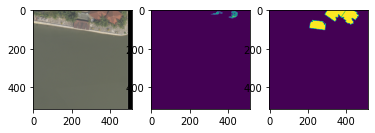

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

idx = '00005'

val_img_dir = f'{images_dir}/processed_image+final_{idx}_a0.png'
val_mask_dir = f'{masks_dir}/mask_{idx}_a0.png'

threshold = 0.95

# read validation image and mask
pil_img = Image.open(val_img_dir)
ground_truth = Image.open(val_mask_dir)

# make predictions
pred_img = np.expand_dims(pil_img, axis = 0)
val_preds = model.predict(pred_img)
val_preds = np.squeeze(val_preds)
val_preds = val_preds > threshold

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(pil_img)
ax2.imshow(val_preds)
ax3.imshow(ground_truth)